In [ ]:
pip install torch numpy matplotlib scipy scikit-learn deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.2/194.2 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 9.8 MB/s eta 0:00:00


PINN for Gravitational Potential of Irregular Bodies
✓ Synthetic asteroid data saved to: asteroid_data.csv
Training PINN with irregular mass distribution...
Epoch 100/500 - Loss: 0.413647, Physics: 0.057306
Epoch 200/500 - Loss: 0.385492, Physics: 0.041935
Epoch 300/500 - Loss: 0.376249, Physics: 0.039360
Epoch 400/500 - Loss: 0.383420, Physics: 0.045937
Epoch 500/500 - Loss: 0.376615, Physics: 0.043538

=== Boundary Condition Tests ===
φ( -5.0,   0.0) =  10.4168
φ(  5.0,   0.0) =  14.0571
φ(  0.0,  -5.0) =  12.6898
φ(  0.0,   5.0) =  12.0200

=== Comparing PINN with Finite Difference Method ===
RMSE: 4.401502
MAE: 3.534295
MAPE: 1133227798124358.500000
R² Score: -1.109622


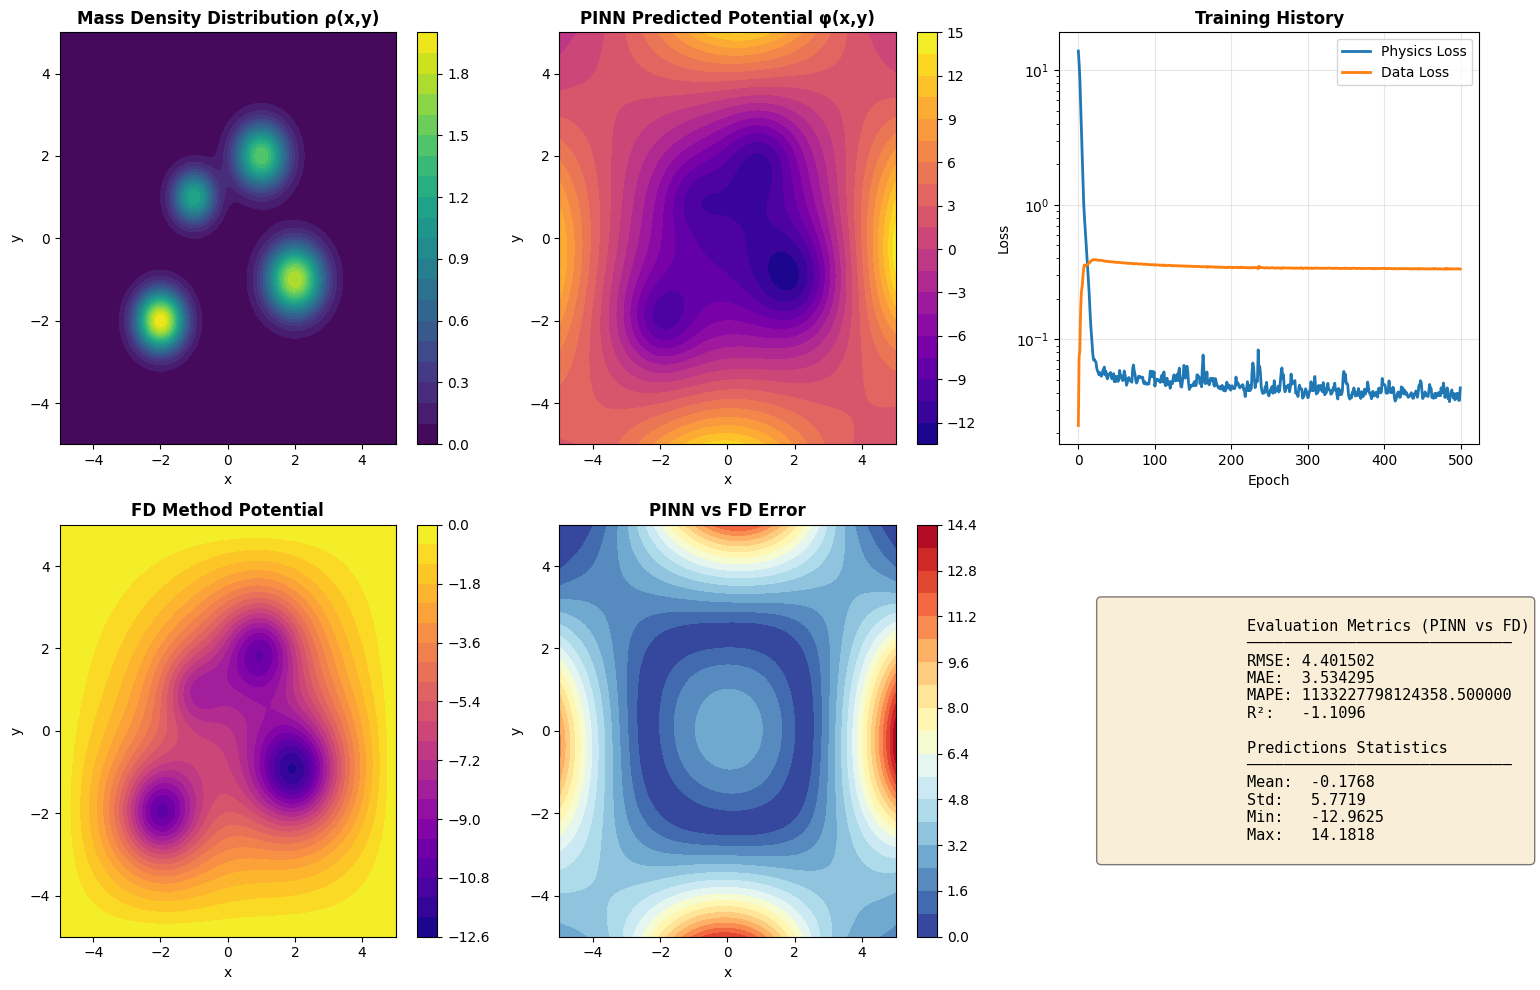


Visualization saved!

Training and evaluation complete!


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import torch
import torch.nn as nn
from torch.optim import Adam, LBFGS
from torch.utils.data import DataLoader, TensorDataset
from scipy.ndimage import laplace
from scipy.interpolate import griddata
import deepxde as dde
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import json
from datetime import datetime

# Set random seeds
np.random.seed(42)
torch.manual_seed(42)
dde.config.set_random_seed(42)

class GravitationalPINN(nn.Module):
    """Physics-Informed Neural Network for gravitational potential"""

    def __init__(self, layers=[2, 128, 128, 128, 1]):
        super(GravitationalPINN, self).__init__()
        self.layers = nn.ModuleList()

        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))

        self.activation = nn.Tanh()

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

class EvaluationMetrics:
    """Compute and store evaluation metrics"""

    @staticmethod
    def compute_metrics(y_true, y_pred):
        """Compute RMSE, MAE, MAPE and R² score"""
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        mape = mean_absolute_percentage_error(y_true, np.maximum(np.abs(y_pred), 1e-8))

        ss_res = np.sum((y_true - y_pred) ** 2)
        ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0

        return {
            'RMSE': rmse,
            'MAE': mae,
            'MAPE': mape,
            'R2': r2,
            'Mean_Pred': np.mean(y_pred),
            'Std_Pred': np.std(y_pred),
            'Min_Pred': np.min(y_pred),
            'Max_Pred': np.max(y_pred)
        }

class MassDistributionGenerator:
    """Generate various mass distributions"""

    def __init__(self, domain_bounds=(-5, 5)):
        self.domain = domain_bounds

    def irregular_asteroid(self, n_points=10000):
        """Generate irregular asteroid-like mass distribution"""
        x_range = np.linspace(self.domain[0], self.domain[1], int(np.sqrt(n_points)))
        y_range = np.linspace(self.domain[0], self.domain[1], int(np.sqrt(n_points)))
        X, Y = np.meshgrid(x_range, y_range)

        rho = np.zeros_like(X)
        centers = [(-2, -2), (1, 2), (2, -1), (-1, 1)]
        amplitudes = [2.0, 1.5, 1.8, 1.2]
        widths = [0.5, 0.6, 0.7, 0.4]

        for (cx, cy), amp, width in zip(centers, amplitudes, widths):
            r = np.sqrt((X - cx)**2 + (Y - cy)**2)
            rho += amp * np.exp(-r**2 / width)

        return X, Y, rho

    def gaussian_blob(self, n_points=10000):
        """Single Gaussian blob"""
        x_range = np.linspace(self.domain[0], self.domain[1], int(np.sqrt(n_points)))
        y_range = np.linspace(self.domain[0], self.domain[1], int(np.sqrt(n_points)))
        X, Y = np.meshgrid(x_range, y_range)

        r = np.sqrt(X**2 + Y**2)
        rho = 3.0 * np.exp(-r**2 / 1.0)
        return X, Y, rho

    def binary_system(self, n_points=10000):
        """Binary mass distribution (e.g., Earth-Moon)"""
        x_range = np.linspace(self.domain[0], self.domain[1], int(np.sqrt(n_points)))
        y_range = np.linspace(self.domain[0], self.domain[1], int(np.sqrt(n_points)))
        X, Y = np.meshgrid(x_range, y_range)

        r1 = np.sqrt((X - 1.5)**2 + Y**2)
        r2 = np.sqrt((X + 1.5)**2 + Y**2)
        rho = 2.0 * np.exp(-r1**2 / 0.4) + 1.5 * np.exp(-r2**2 / 0.3)
        return X, Y, rho

    def synthetic_asteroid_data(self, filepath='asteroid_data.csv'):
        """Generate and save synthetic asteroid data"""
        X, Y, rho = self.irregular_asteroid(n_points=5000)
        x_flat = X.flatten()
        y_flat = Y.flatten()
        rho_flat = rho.flatten()

        data = np.column_stack([x_flat, y_flat, rho_flat])
        np.savetxt(filepath, data, delimiter=',', header='x,y,rho', comments='')
        return filepath

    def load_asteroid_data(self, filepath):
        """Load asteroid mass data from CSV"""
        data = np.loadtxt(filepath, delimiter=',', skiprows=1)
        x = data[:, 0]
        y = data[:, 1]
        rho = data[:, 2]

        X_unique = np.unique(x)
        Y_unique = np.unique(y)
        if len(X_unique) > 1 and len(Y_unique) > 1:
            X, Y = np.meshgrid(X_unique, Y_unique)
            rho = griddata((x, y), rho, (X, Y), method='nearest')
        else:
            X = x.reshape(-1, 1)
            Y = y.reshape(-1, 1)

        return X, Y, rho

class FiniteDifferenceSolver:
    """Solve Poisson equation using Finite Difference Method"""

    def __init__(self, G=1.0):
        self.G = G

    def solve_poisson_fd(self, X, Y, rho, iterations=1000, tolerance=1e-6):
        """Solve ∇²φ = 4πGρ using Jacobi iteration"""
        phi = np.zeros_like(X)
        dx = X[0, 1] - X[0, 0]
        dy = Y[1, 0] - Y[0, 0]

        for iteration in range(iterations):
            phi_old = phi.copy()

            phi[1:-1, 1:-1] = (
                (phi[:-2, 1:-1] + phi[2:, 1:-1]) / (dx**2) +
                (phi[1:-1, :-2] + phi[1:-1, 2:]) / (dy**2) -
                4 * np.pi * self.G * rho[1:-1, 1:-1]
            ) / (2.0 / (dx**2) + 2.0 / (dy**2))

            error = np.max(np.abs(phi - phi_old))
            if error < tolerance:
                print(f"FD converged in {iteration} iterations")
                break

        return phi

class PoissonPINN:
    """PINN solver for Poisson equation using PyTorch"""

    def __init__(self, domain_bounds=(-5, 5), G=1.0):
        self.domain = domain_bounds
        self.G = G
        self.model = GravitationalPINN()
        self.optimizer = Adam(self.model.parameters(), lr=0.001)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        self.history = {
            'loss': [], 'physics_loss': [], 'data_loss': [],
            'epoch': [], 'metrics': []
        }
        self.mass_gen = MassDistributionGenerator(domain_bounds)
        self.metrics = None

    def train(self, mass_type='irregular', epochs=500, batch_size=512,
              test_boundary_conditions=True):
        """Train PINN with specified mass distribution"""

        if mass_type == 'irregular':
            X, Y, rho = self.mass_gen.irregular_asteroid()
        elif mass_type == 'gaussian':
            X, Y, rho = self.mass_gen.gaussian_blob()
        elif mass_type == 'binary':
            X, Y, rho = self.mass_gen.binary_system()
        else:
            raise ValueError("Unknown mass type")

        self.X, self.Y, self.rho = X, Y, rho

        x_data = X.flatten()
        y_data = Y.flatten()
        rho_data = rho.flatten()

        x_train = torch.FloatTensor(x_data).to(self.device)
        y_train = torch.FloatTensor(y_data).to(self.device)
        rho_train = torch.FloatTensor(rho_data).to(self.device)

        dataset = TensorDataset(x_train, y_train, rho_train)
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        print(f"Training PINN with {mass_type} mass distribution...")

        for epoch in range(epochs):
            total_loss = 0.0
            total_physics_loss = 0.0
            total_data_loss = 0.0

            for batch_idx, (x_batch, y_batch, rho_batch) in enumerate(dataloader):
                self.optimizer.zero_grad()

                laplacian, phi_pred = self.compute_laplacian(x_batch, y_batch)

                physics_loss = nn.MSELoss()(laplacian, 4 * np.pi * self.G * rho_batch.unsqueeze(1))
                data_loss = 0.01 * nn.MSELoss()(phi_pred, torch.zeros_like(phi_pred))

                loss = physics_loss + data_loss
                loss.backward()
                self.optimizer.step()

                total_loss += loss.item()
                total_physics_loss += physics_loss.item()
                total_data_loss += data_loss.item()

            avg_loss = total_loss / len(dataloader)
            avg_physics_loss = total_physics_loss / len(dataloader)
            avg_data_loss = total_data_loss / len(dataloader)

            self.history['loss'].append(avg_loss)
            self.history['physics_loss'].append(avg_physics_loss)
            self.history['data_loss'].append(avg_data_loss)
            self.history['epoch'].append(epoch)

            if (epoch + 1) % 100 == 0:
                print(f"Epoch {epoch+1}/{epochs} - Loss: {avg_loss:.6f}, Physics: {avg_physics_loss:.6f}")

        # Test boundary conditions if requested
        if test_boundary_conditions:
            self.test_boundary_conditions()

    def compute_laplacian(self, x, y, create_graph=True):
        """Compute Laplacian using automatic differentiation"""
        x = x.clone().detach().requires_grad_(True)
        y = y.clone().detach().requires_grad_(True)

        xy = torch.cat([x.unsqueeze(1), y.unsqueeze(1)], dim=1)
        phi_pred = self.model(xy)

        dphi_dxy = torch.autograd.grad(
            outputs=phi_pred.sum(),
            inputs=xy,
            create_graph=True,
            retain_graph=True
        )[0]

        dphi_dx = dphi_dxy[:, 0].unsqueeze(1)
        dphi_dy = dphi_dxy[:, 1].unsqueeze(1)

        d2phi_dx2 = torch.autograd.grad(
            outputs=dphi_dx.sum(),
            inputs=xy,
            create_graph=create_graph,
            retain_graph=True
        )[0][:, 0].unsqueeze(1)

        d2phi_dy2 = torch.autograd.grad(
            outputs=dphi_dy.sum(),
            inputs=xy,
            create_graph=create_graph
        )[0][:, 1].unsqueeze(1)

        laplacian = d2phi_dx2 + d2phi_dy2
        return laplacian, phi_pred

    def test_boundary_conditions(self):
        """Test boundary conditions"""
        print("\n=== Boundary Condition Tests ===")
        boundary_points = [
            (self.domain[0], 0), (self.domain[1], 0),
            (0, self.domain[0]), (0, self.domain[1])
        ]

        self.model.eval()
        with torch.no_grad():
            for x, y in boundary_points:
                xy = torch.FloatTensor([[x, y]]).to(self.device)
                phi = self.model(xy).item()
                print(f"φ({x:5.1f}, {y:5.1f}) = {phi:8.4f}")

    def compare_with_fd(self):
        """Compare PINN results with Finite Difference solution"""
        print("\n=== Comparing PINN with Finite Difference Method ===")

        fd_solver = FiniteDifferenceSolver(self.G)
        phi_fd = fd_solver.solve_poisson_fd(self.X, self.Y, self.rho)

        phi_pinn = self.predict(self.X.flatten(), self.Y.flatten())
        phi_pinn = phi_pinn.reshape(self.X.shape)

        error = np.abs(phi_pinn - phi_fd)
        metrics = EvaluationMetrics.compute_metrics(phi_fd.flatten(), phi_pinn.flatten())

        print(f"RMSE: {metrics['RMSE']:.6f}")
        print(f"MAE: {metrics['MAE']:.6f}")
        print(f"MAPE: {metrics['MAPE']:.6f}")
        print(f"R² Score: {metrics['R2']:.6f}")

        return phi_fd, phi_pinn, error, metrics

    def predict(self, x_test, y_test):
        """Predict gravitational potential"""
        self.model.eval()
        with torch.no_grad():
            xy_test = torch.cat([
                torch.FloatTensor(x_test).unsqueeze(1).to(self.device),
                torch.FloatTensor(y_test).unsqueeze(1).to(self.device)
            ], dim=1)
            phi_pred = self.model(xy_test).cpu().numpy()
        return phi_pred

    def visualize_results(self, phi_fd=None, error_fd=None, metrics_dict=None):
        """Comprehensive visualization"""
        x_test = self.X.flatten()
        y_test = self.Y.flatten()
        phi_pinn = self.predict(x_test, y_test)
        phi_grid = phi_pinn.reshape(self.X.shape)

        if phi_fd is not None:
            fig, axes = plt.subplots(2, 3, figsize=(16, 10))
        else:
            fig, axes = plt.subplots(2, 2, figsize=(12, 10))

        # Mass distribution
        im1 = axes[0, 0].contourf(self.X, self.Y, self.rho, levels=20, cmap='viridis')
        axes[0, 0].set_title('Mass Density Distribution ρ(x,y)', fontsize=12, fontweight='bold')
        axes[0, 0].set_xlabel('x')
        axes[0, 0].set_ylabel('y')
        plt.colorbar(im1, ax=axes[0, 0])

        # PINN Potential
        im2 = axes[0, 1].contourf(self.X, self.Y, phi_grid, levels=20, cmap='plasma')
        axes[0, 1].set_title('PINN Predicted Potential φ(x,y)', fontsize=12, fontweight='bold')
        axes[0, 1].set_xlabel('x')
        axes[0, 1].set_ylabel('y')
        plt.colorbar(im2, ax=axes[0, 1])

        # Training loss
        axes[0, 2].semilogy(self.history['epoch'], self.history['physics_loss'],
                            label='Physics Loss', linewidth=2)
        axes[0, 2].semilogy(self.history['epoch'], self.history['data_loss'],
                            label='Data Loss', linewidth=2)
        axes[0, 2].set_xlabel('Epoch')
        axes[0, 2].set_ylabel('Loss')
        axes[0, 2].set_title('Training History', fontsize=12, fontweight='bold')
        axes[0, 2].legend()
        axes[0, 2].grid(True, alpha=0.3)

        # FD Potential
        if phi_fd is not None:
            im3 = axes[1, 0].contourf(self.X, self.Y, phi_fd, levels=20, cmap='plasma')
            axes[1, 0].set_title('FD Method Potential', fontsize=12, fontweight='bold')
            axes[1, 0].set_xlabel('x')
            axes[1, 0].set_ylabel('y')
            plt.colorbar(im3, ax=axes[1, 0])

            # Error
            im4 = axes[1, 1].contourf(self.X, self.Y, error_fd, levels=20, cmap='RdYlBu_r')
            axes[1, 1].set_title('PINN vs FD Error', fontsize=12, fontweight='bold')
            axes[1, 1].set_xlabel('x')
            axes[1, 1].set_ylabel('y')
            cbar = plt.colorbar(im4, ax=axes[1, 1])

            # Metrics text
            axes[1, 2].axis('off')
            if metrics_dict:
                metrics_text = f"""
                Evaluation Metrics (PINN vs FD)
                ─────────────────────────────
                RMSE: {metrics_dict['RMSE']:.6f}
                MAE:  {metrics_dict['MAE']:.6f}
                MAPE: {metrics_dict['MAPE']:.6f}
                R²:   {metrics_dict['R2']:.4f}

                Predictions Statistics
                ─────────────────────────────
                Mean:  {metrics_dict['Mean_Pred']:.4f}
                Std:   {metrics_dict['Std_Pred']:.4f}
                Min:   {metrics_dict['Min_Pred']:.4f}
                Max:   {metrics_dict['Max_Pred']:.4f}
                """
                axes[1, 2].text(0.1, 0.5, metrics_text, fontsize=11, family='monospace',
                               verticalalignment='center', bbox=dict(boxstyle='round',
                               facecolor='wheat', alpha=0.5))
        else:
            axes[1, 0].axis('off')
            axes[1, 1].axis('off')
            axes[1, 2].axis('off')

        plt.tight_layout()
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        plt.savefig(f'pinn_gravitational_potential_{timestamp}.png', dpi=150, bbox_inches='tight')
        plt.show()
        print(f"\nVisualization saved!")

# Main execution
if __name__ == "__main__":
    print("=" * 60)
    print("PINN for Gravitational Potential of Irregular Bodies")
    print("=" * 60)

    # Generate synthetic asteroid data
    mass_gen = MassDistributionGenerator()
    asteroid_file = mass_gen.synthetic_asteroid_data()
    print(f"✓ Synthetic asteroid data saved to: {asteroid_file}")

    # Train PINN
    pinn = PoissonPINN(domain_bounds=(-5, 5), G=1.0)
    pinn.train(mass_type='irregular', epochs=500, batch_size=512, test_boundary_conditions=True)

    # Compare with Finite Difference
    phi_fd, phi_pinn, error, metrics = pinn.compare_with_fd()

    # Visualization
    pinn.visualize_results(phi_fd=phi_fd, error_fd=error, metrics_dict=metrics)

    print("\n" + "=" * 60)
    print("Training and evaluation complete!")
    print("=" * 60)